In [1]:
from data_processing_helper import * 

In [2]:
# Load a subject's data 
filename = "B0203T.csv"
eeg_filename = "./data/BCI_Competition/train/" + filename
event_filename = "./data/BCI_Competition/y/" + filename

eeg_chans = ["C3", "Cz", "C4"] # 10-20 system 
eog_chans = ["EOG:ch01", "EOG:ch02", "EOG:ch03"] 
all_chans = eeg_chans + eog_chans
event_types = {1:"left", 2:"right"}

# Load the raw csvs into dataframes
eeg_df = pd.read_csv(eeg_filename)
event_df = pd.read_csv(event_filename, names=["EventType"])

In [3]:
eeg_df.head(2)

,time,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03,EventStart
0,0,-2.783883,-6.422466,-4.224664,21.978022,-11.233211,1.465201,0
1,4,-1.367521,-4.322344,-2.075702,23.443223,-12.210012,-4.395604,0


In [4]:
event_df.head(2)

,EventType
0,2
1,1


In [6]:
# Extract data from raw dataframes for constructing trial-by-trial dataframe
trial_duration_ms = 4000
epochs = []
epoch_times = []
labels = []
start_df = eeg_df[eeg_df['EventStart'] == 1]
for i, event_type in enumerate(event_df["EventType"].values): 
    labels.append(event_type)
    start_time = start_df.iloc[i]["time"]
    end_time = int(start_time + trial_duration_ms)
    epoch_times.append((start_time, end_time))
    sub_df = eeg_df[(eeg_df['time'] > start_time) & (eeg_df['time'] <= end_time)]
    eeg_dat = []
    for ch in all_chans: 
        eeg_dat.append(sub_df[ch].values)
    epochs.append(np.array(eeg_dat))
    
# Create dataframe from the data extracted previously
eeg_epoch_df = getDF(epochs, labels, epoch_times, all_chans)

In [7]:
# Preview dataframe of trials
eeg_epoch_df.head(2)

,start_time,event_type,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,220396.0,2,"[-0.6105006105006106, 2.1245421245421245, 0.97...","[0.21978021978021972, 0.5128205128205128, -0.6...","[3.7118437118437115, 3.1257631257631258, 1.880...","[2.4420024420024418, 7.814407814407812, 8.3028...","[7.326007326007326, 11.72161172161172, 8.30280...","[7.814407814407812, 10.744810744810744, 14.163..."
1,230352.0,1,"[-3.0769230769230766, -2.173382173382173, -1.2...","[-1.636141636141636, -1.5384615384615383, -0.7...","[-0.3663003663003662, -1.1965811965811963, 0.0...","[9.27960927960928, -0.9768009768009768, -0.976...","[12.698412698412698, 4.884004884004884, 4.3956...","[9.768009768009767, 1.4652014652014649, -1.465..."


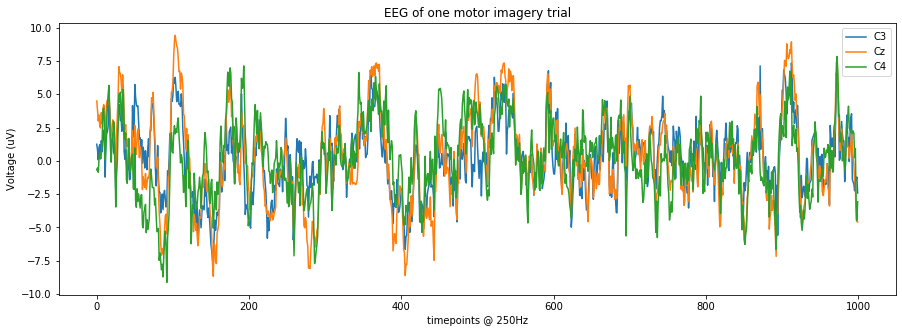

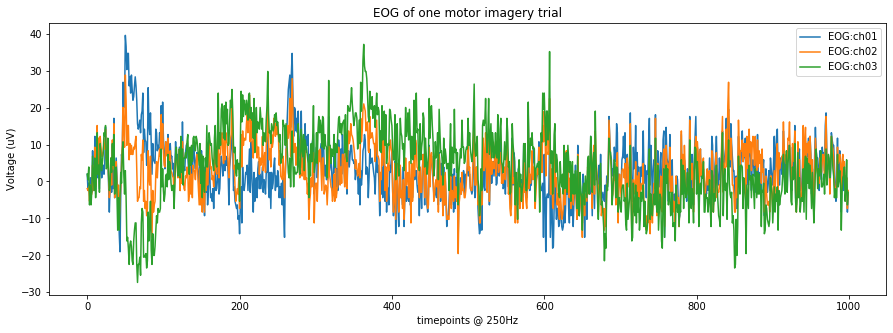

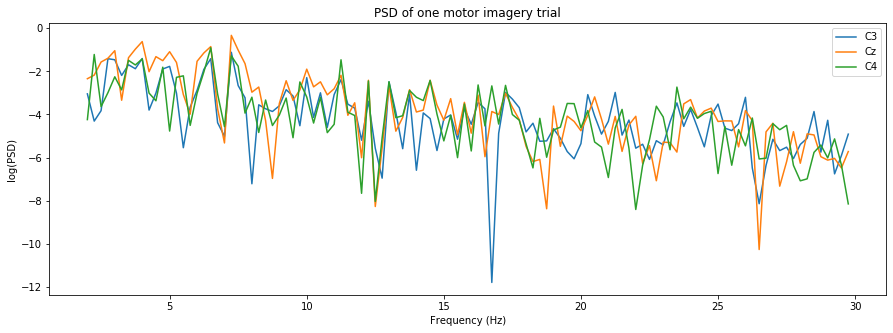

In [8]:
# Visualize EEG and PSD for one trial
trial_num = 2

plt.figure(figsize=(15,5))
for ch in eeg_chans: 
    plt.plot(eeg_epoch_df[ch][trial_num], label=ch)
plt.ylabel("Voltage (uV)")
plt.xlabel("timepoints @ 250Hz")
plt.title("EEG of one motor imagery trial")
plt.legend() 
plt.show()

plt.figure(figsize=(15,5))
for ch in eog_chans: 
    plt.plot(eeg_epoch_df[ch][trial_num], label=ch)
plt.ylabel("Voltage (uV)")
plt.xlabel("timepoints @ 250Hz")
plt.title("EOG of one motor imagery trial")
plt.legend() 
plt.show()

plt.figure(figsize=(15,5))
for ch in eeg_chans: 
    plotPSD_fromEEG(eeg_epoch_df.iloc[trial_num][ch], pre_cut_off_freq=2, post_cut_off_freq=30, label=ch)
plt.title("PSD of one motor imagery trial")
plt.legend()
plt.show()


In [9]:
# Get PSD averages for each channel for each event type (1=left or 2=right)
psd_averages_by_type = {}

for event_type in range(1, 3): 
    psds_only_one_type={}
    freqs_only_one_type={}
    for i, row in eeg_epoch_df[eeg_epoch_df["event_type"] == event_type].iterrows(): 
        for ch in eeg_chans: 
            if ch not in psds_only_one_type: 
                psds_only_one_type[ch] = list()
                freqs_only_one_type[ch] = list()
            f, p = getMeanFreqPSD(row[ch])
            psds_only_one_type[ch].append(p)
            freqs_only_one_type[ch].append(f)
    avg_psds_one_type = {}
    for ch in eeg_chans:
        psds_only_one_type[ch] = np.array(psds_only_one_type[ch])
        avg_psds_one_type[ch] = np.mean(psds_only_one_type[ch], axis=0)
    psd_averages_by_type[event_type] = dict(avg_psds_one_type)

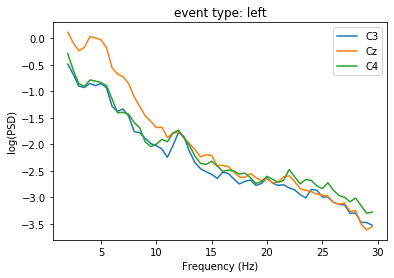

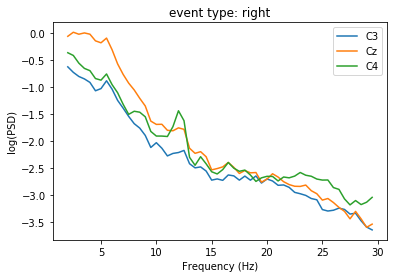

In [10]:
# View Average PSDs
for event_type in range(1, 3): 
    for ch in eeg_chans[:]: 
        plotPSD(freqs_only_one_type[eeg_chans[0]][0], psd_averages_by_type[event_type][ch],pre_cut_off_freq=2, post_cut_off_freq=30, label=ch)

    plt.legend()
    plt.title("event type: " + event_types[event_type])
    plt.show()

In [17]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [23]:
print('Signal to noise ratio for 3 channels: \n')
print('C3: ' + str(signaltonoise(eeg_df['C3'])))
print('Cz: ' + str(signaltonoise(eeg_df['Cz'])))
print('C4: ' + str(signaltonoise(eeg_df['C4'])))

Signal to noise ratio for 3 channels: 

C3: 0.027986427901115274
Cz: 0.024731805463047037
C4: 0.024302128621544333


In [25]:
print('Mean voltage for 3 channels: \n')

print('C3: ' + str(eeg_df['C3'].mean()))
print('Cz: ' + str(eeg_df['Cz'].mean()))
print('C4: ' + str(eeg_df['C4'].mean()))

Mean voltage for 3 channels: 

C3: 0.11074833968048235
Cz: 0.10619279018843825
C4: 0.10577663094602152


In [26]:
print('Standard deviation for 3 channels: \n')

print('C3: ' + str(eeg_df['C3'].std()))
print('Cz: ' + str(eeg_df['Cz'].std()))
print('C4: ' + str(eeg_df['C4'].std()))

Standard deviation for 3 channels: 

C3: 3.95722024164736
Cz: 4.293778905101911
C4: 4.352571189907952
